<a href="https://colab.research.google.com/github/bala-101/market_prediction_nifty_50/blob/main/Prediction_io.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

class StockPredictionModels:
    def __init__(self):
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        self.imputer = SimpleImputer(strategy='mean')

    def calculate_rsi(self, prices, period=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        exp1 = prices.ewm(span=fast, adjust=False).mean()
        exp2 = prices.ewm(span=slow, adjust=False).mean()
        macd = exp1 - exp2
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        return macd - signal_line

    def calculate_bollinger_bands(self, prices, window=20, num_std=2):
        sma = prices.rolling(window=window).mean()
        std = prices.rolling(window=window).std()
        upper_band = sma + (std * num_std)
        lower_band = sma - (std * num_std)
        return upper_band, lower_band

    def prepare_data(self, df, lookback=60):
        try:
            df['Returns'] = df['Close'].pct_change()
            df['MA7'] = df['Close'].rolling(window=7).mean()
            df['MA21'] = df['Close'].rolling(window=21).mean()
            df['RSI'] = self.calculate_rsi(df['Close'])
            df['MACD'] = self.calculate_macd(df['Close'])
            df['BB_upper'], df['BB_lower'] = self.calculate_bollinger_bands(df['Close'])
            df['Volume_MA7'] = df['Volume'].rolling(window=7).mean()
            df['Price_std'] = df['Close'].rolling(window=7).std()
            df = df.ffill().bfill()

            features = ['Close', 'Returns', 'MA7', 'MA21', 'RSI', 'MACD',
                        'BB_upper', 'BB_lower', 'Volume', 'Volume_MA7', 'Price_std']

            X, y = [], []
            for i in range(len(df) - lookback):
                X.append(df[features].values[i:(i + lookback)])
                y.append(df['Close'].values[i + lookback])

            X = np.array(X)
            y = np.array(y)

            X_reshaped = X.reshape(X.shape[0], -1)
            X_reshaped = self.imputer.fit_transform(X_reshaped)

            X_scaled = self.feature_scaler.fit_transform(X_reshaped)
            y_scaled = self.target_scaler.fit_transform(y.reshape(-1, 1))

            return X_scaled, y_scaled

        except Exception as e:
            print(f"Error in data preparation: {str(e)}")
            return None, None

    def train_xgboost(self, X_train, y_train):
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=5,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(X_train, y_train.ravel())
        return model

    def train_random_forest(self, X_train, y_train):
        model = RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        model.fit(X_train, y_train.ravel())
        return model

    def train_svr(self, X_train, y_train):
        model = SVR(kernel='rbf', C=100.0, epsilon=0.1, gamma='scale')
        model.fit(X_train, y_train.ravel())
        return model

    def evaluate_model(self, model, X_test, y_test, model_name):
        predictions = model.predict(X_test)
        predictions = self.target_scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test_orig = self.target_scaler.inverse_transform(y_test.reshape(-1, 1))

        mse = mean_squared_error(y_test_orig, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_orig, predictions)
        r2 = r2_score(y_test_orig, predictions)

        print(f"\n{model_name} Performance Metrics:")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R² Score: {r2:.4f}")

        return predictions, y_test_orig

    def plot_predictions(self, predictions, y_test, model_name):
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.title(f'{model_name} - Actual vs Predicted NIFTY 50 Prices')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def plot_model_comparison(self, predictions_dict, y_test):
        plt.figure(figsize=(14, 7))
        plt.plot(y_test, label='Actual Price', color='black')

        for model_name, predictions in predictions_dict.items():
            plt.plot(predictions, label=f'{model_name} Predicted Price')

        plt.title('Comparison of Model Predictions vs Actual Price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def train_and_evaluate_all_models(self, df):
        X, y = self.prepare_data(df)
        if X is None or y is None:
            print("Error preparing data. Exiting...")
            return None

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        models = {
            'XGBoost': self.train_xgboost,
            'Random Forest': self.train_random_forest,
            'SVR': self.train_svr
        }

        results = {}
        predictions_dict = {}

        for name, train_func in models.items():
            try:
                print(f"\nTraining {name}...")
                model = train_func(X_train, y_train)
                predictions, y_test_orig = self.evaluate_model(model, X_test, y_test, name)
                predictions_dict[name] = predictions.flatten()  # Save predictions for comparison plot
                results[name] = model
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue

        # Plot comparison of all models
        self.plot_model_comparison(predictions_dict, y_test_orig.flatten())

        return results


[*********************100%***********************]  1 of 1 completed

Fetching NIFTY data from start='2020-01-01', end='2023-01-01'
Retrieved 746 days of data



Training XGBoost...

XGBoost Performance Metrics:
MSE: 103673.96
RMSE: 321.98
MAE: 264.53
R² Score: 0.8785

Training Random Forest...

Random Forest Performance Metrics:
MSE: 71853.39
RMSE: 268.05
MAE: 210.81
R² Score: 0.9158

Training SVR...

SVR Performance Metrics:
MSE: 814448.60
RMSE: 902.47
MAE: 799.32
R² Score: 0.0454


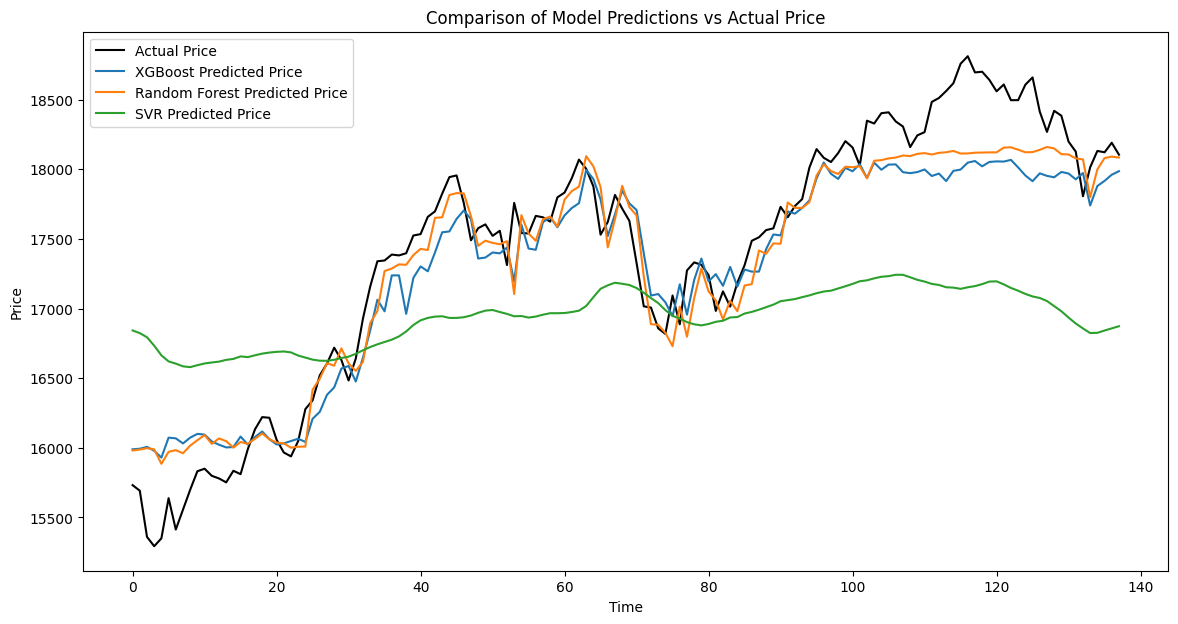

In [ ]:
predictor = StockPredictionModels()

# Calculate date range for last 3 years
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

# Get data
print(f"Fetching NIFTY data from start='2020-01-01', end='2023-01-01'")
nifty_data = yf.download('^NSEI', start='2020-01-01', end='2023-01-01')

if nifty_data.empty:
    print("Error: No data retrieved")
else:
    print(f"Retrieved {len(nifty_data)} days of data")

    # Train and evaluate all models
    models = predictor.train_and_evaluate_all_models(nifty_data)

In [ ]:
if models is not None:
    try:
        close = float(input("Enter closing price: "))
        volume = float(input("Enter trading volume: "))

        user_input = {
            'Close': close,
            'Volume': volume
        }

        print("\nPredictions from different models:")
        for name, model in models.items():
            try:
                price = predictor.predict_price(model, user_input, nifty_data.tail(60))
                if price is not None:
                    print(f"{name}: {price:.2f}")
            except Exception as e:
                print(f"Error getting prediction from {name}: {str(e)}")
    except ValueError:
        print("Please enter valid numerical values")

Enter closing price: 24300
